# DoubleML meets FLAML: Tuning XGBoost learners

In this example notebook, we will be illustrating how one can use [FLAML (Fast Library for Automated Machine Learning & Tuning)](https://github.com/microsoft/FLAML) to tune hyperparameters of an XGBoost learner in the [DoubleML](https://docs.doubleml.org/stable/index.html) Framework. 

## Data

For the first part of this tutorial, we're going to use simulated data by calling [`make_plr_CCDDHNR2018`](https://docs.doubleml.org/stable/api/generated/doubleml.datasets.make_plr_CCDDHNR2018.html). This function generates data from a partially linear regression model used in [Chernozhukov et al. (2018)](https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097) for Figure 1. We generate 1000 observations out of which 500 are used for tuning the XGB learners using FLAML and the rest 500 are used to train the DoubleML model. The data generated will have 50 covariates variables, 1 treatment variable and 1 outcome variable. We have set the treatment effect to be $ 0.5 $ for this particular example

In [1]:
# ! pip install flaml;

In [2]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from doubleml.datasets import make_plr_CCDDHNR2018

import doubleml as dml
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

In [3]:
sns.set()
colors = sns.color_palette()

In [4]:
plt.rcParams['figure.figsize'] = 10., 7.5
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'axes.spines.top': False,
                            'axes.spines.bottom': False,
                            'axes.spines.left': False,
                            'axes.spines.right': False})

In [5]:
data = make_plr_CCDDHNR2018(alpha=0.5, n_obs=1000, dim_x=50, return_type="DataFrame")

In [6]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X43,X44,X45,X46,X47,X48,X49,X50,y,d
0,1.657222,0.946716,0.377960,1.232567,0.548446,-0.601472,-0.639983,-0.888613,-0.109892,0.865485,...,1.662351,0.056852,0.345201,-0.933119,-0.864177,-1.455819,0.277421,0.432555,3.820768,2.871799
1,-0.140373,0.318178,1.326577,-0.038081,-0.081526,0.525032,0.173963,0.988939,2.052082,1.225609,...,2.366273,1.660631,0.169173,0.115305,0.005049,0.129702,-0.257108,0.717411,2.782493,-0.683040
2,-1.230496,-1.147915,0.057384,0.822233,0.316933,0.321593,-0.138514,-0.999075,0.231421,-0.651108,...,-1.443120,-0.648600,-1.081062,-0.834230,-1.232478,-0.582722,-0.313851,-1.424137,0.643945,-0.527346
3,-0.033224,0.826516,0.348916,-0.558627,-1.092446,-0.445529,-0.404820,-0.860091,-1.155255,-2.058850,...,-0.282183,-1.089843,-0.759434,-1.019423,-1.391079,-1.443890,-0.215652,-0.836138,-0.003038,0.383504
4,-1.542770,-1.374956,-0.221876,-0.104524,-0.618885,-0.505555,-0.764899,0.402509,-0.308056,-0.364675,...,-0.185257,-0.911834,0.707109,0.537942,0.487548,0.740012,0.361188,0.309118,-2.316022,-2.028819


In [7]:
data_flaml, data_dml = train_test_split(data, test_size=0.5)

## Hyperparameter Tuning using FLAML

We will be training two [`XGBRegressor`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) models: first one for estimatating the nuisance function $ l_{\theta}(X) = E[Y|X] $, and the second one to estimate the nuisance function $ m_{\theta}(X) = E[D|X] $. We will be doing so by minimizing the mean squared error between the true values and the predictions

In [8]:
automl_l = AutoML()
settings = {
    "time_budget": 120,  # total running time in seconds
    "metric": 'mse',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['xgboost'],  # list of ML learners; we tune xgboost in this example
    "task": 'regression',  # task type    
}

automl_l.fit(X_train=data_flaml.drop(columns = ["y", "d"]).values, y_train=data_flaml["y"].values, verbose=2, **settings)

[flaml.automl: 07-08 11:24:41] {2322} WARNING - Time taken to find the best model is 83% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


In [9]:
# retrieve best config
print('Best hyperparmeter config:', automl_l.best_config)
print('Best mse on validation data: {0:.4g}'.format(automl_l.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl_l.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 9, 'max_leaves': 8, 'min_child_weight': 45.63982015489896, 'learning_rate': 0.8271174453352466, 'subsample': 0.8887851542660552, 'colsample_bylevel': 0.8861407627871792, 'colsample_bytree': 0.6360227175852697, 'reg_alpha': 0.24333444176621818, 'reg_lambda': 0.149045122688325}
Best mse on validation data: 1.37
Training duration of best run: 0.01917 s


In [10]:
automl_l.model.estimator

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.8861407627871792, colsample_bynode=1,
             colsample_bytree=0.6360227175852697, gamma=0, gpu_id=-1,
             grow_policy='lossguide', importance_type='gain',
             interaction_constraints='', learning_rate=0.8271174453352466,
             max_delta_step=0, max_depth=0, max_leaves=8,
             min_child_weight=45.63982015489896, missing=nan,
             monotone_constraints='()', n_estimators=1, n_jobs=-1,
             num_parallel_tree=1, random_state=0, reg_alpha=0.24333444176621818,
             reg_lambda=0.149045122688325, scale_pos_weight=1,
             subsample=0.8887851542660552, tree_method='hist',
             use_label_encoder=False, validate_parameters=1, verbosity=0)

In [11]:
automl_m = AutoML()
settings = {
    "time_budget": 120,  # total running time in seconds
    "metric": 'mse',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['xgboost'],  # list of ML learners; we tune xgboost in this example
    "task": 'regression',  # task type    
}

automl_m.fit(X_train=data_flaml.drop(columns = ["y", "d"]).values, y_train=data_flaml["d"].values, verbose=2, **settings)

In [12]:
# retrieve best config
print('Best hyperparmeter config:', automl_m.best_config)
print('Best mse on validation data: {0:.4g}'.format(automl_m.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl_m.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 23, 'max_leaves': 9, 'min_child_weight': 42.84308837737722, 'learning_rate': 1.0, 'subsample': 0.9908960911521747, 'colsample_bylevel': 0.7908024341286631, 'colsample_bytree': 0.7922331300866388, 'reg_alpha': 0.02047249913685125, 'reg_lambda': 0.5100784572580507}
Best mse on validation data: 1.173
Training duration of best run: 0.01911 s


In [13]:
automl_m.model.estimator

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.7908024341286631, colsample_bynode=1,
             colsample_bytree=0.7922331300866388, gamma=0, gpu_id=-1,
             grow_policy='lossguide', importance_type='gain',
             interaction_constraints='', learning_rate=1.0, max_delta_step=0,
             max_depth=0, max_leaves=9, min_child_weight=42.84308837737722,
             missing=nan, monotone_constraints='()', n_estimators=1, n_jobs=-1,
             num_parallel_tree=1, random_state=0, reg_alpha=0.02047249913685125,
             reg_lambda=0.5100784572580507, scale_pos_weight=1,
             subsample=0.9908960911521747, tree_method='hist',
             use_label_encoder=False, validate_parameters=1, verbosity=0)

## Overfit Check
Before continuing with the DML experiments, we make sure that the estimators trained by FLAML are not overfitted to the data they're trained. For this, we compare the in-sample (MSE for FLAML data) and out-of-sample (MSE for DML data) and verify if they vary significantly.

In [14]:
# Check for Overfitting: Compare in-sample (train), out-of-sample (test) MSE

# ml_l
pres_ins_ml_l = automl_l.model.estimator.predict(data_flaml.drop(columns = ["y", "d"]).values)
mse_ins_ml_l = np.mean((pres_ins_ml_l - data_flaml.y.values)**2)
pres_oos_ml_l = automl_l.model.estimator.predict(data_dml.drop(columns = ["y", "d"]).values)
mse_oos_ml_l = np.mean((pres_oos_ml_l - data_dml.y.values)**2)

# ml_m
pres_ins_ml_m = automl_m.model.estimator.predict(data_flaml.drop(columns = ["y", "d"]).values)
mse_ins_ml_m = np.mean((pres_ins_ml_m - data_flaml.d.values)**2)
pres_oos_ml_m = automl_m.model.estimator.predict(data_dml.drop(columns = ["y", "d"]).values)
mse_oos_ml_m = np.mean((pres_oos_ml_m - data_dml.d.values)**2)

In [15]:
print("ins mse, ml_l:", mse_ins_ml_l)
print("oos mse, ml_l:", mse_oos_ml_l)

print("ins mse, ml_m:", mse_ins_ml_m)
print("oos mse, ml_m:", mse_oos_ml_m)

ins mse, ml_l: 1.2759536289191706
oos mse, ml_l: 1.3618780092147345
ins mse, ml_m: 0.9963568938504447
oos mse, ml_m: 1.0363425121122045


As we can observe, the MSE on training data is a little lower than validation data (DML data). However, this is not very significant and we can use these estimators for DML.

## Double / Debiased Machine Learning

Now that we have our tuned XGB Learners, we can train our Double Machine Learning model.

In [16]:
obj_dml_data = dml.DoubleMLData(data_dml, "y", "d")
print(obj_dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50']
Instrument variable(s): None
No. Observations: 500

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 261 to 256
Columns: 52 entries, X1 to d
dtypes: float64(52)
memory usage: 207.0 KB



In [17]:
def print_scores(dml_plr_obj, return_scores=False):
    # export data, fitted coefficient and predictions of the DoubleML model
    y = dml_plr_obj._dml_data.y
    d = dml_plr_obj._dml_data.d

    y_preds_ml_l = dml_plr_obj.predictions['ml_l'][:, 0, 0]
    y_preds_ml_m = dml_plr_obj.predictions['ml_m'][:, 0, 0]

    if return_scores:
        return mean_squared_error(y, y_preds_ml_l), mean_squared_error(y, y_preds_ml_m)

    print(f"The mean squared error for l_of_X: {mean_squared_error(y, y_preds_ml_l):.3f}")
    print(f"The mean squared error for m_of_X: {mean_squared_error(y, y_preds_ml_m):.3f}")

### Tuned Learner

In [18]:
dml_plr_obj_tuned = dml.DoubleMLPLR(obj_dml_data, automl_l.model.estimator, automl_m.model.estimator)
automl_tuned_summary = dml_plr_obj_tuned.fit(store_predictions = True).summary
automl_tuned_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
d,0.477797,0.050482,9.464661,2.945135e-21,0.378854,0.576741


As we can observe the coefficient i.e. the treatment effect calculated by our model is very close to the actual treatment effect of $ 0.5 $ and the standard error is also very low. Now will also evaluate the learners themselves by calculating their mean squared error.

In [19]:
print_scores(dml_plr_obj_tuned)

The mean squared error for l_of_X: 1.368
The mean squared error for m_of_X: 1.665


### Untuned XGB Learners

Now we compare these metrics with DoubleML model that uses untuned XGB learners

In [20]:
ml_l = ml_m = xgb.XGBRegressor()

dml_plr_obj_untuned = dml.DoubleMLPLR(obj_dml_data, ml_l, ml_m)
untuned_summary = dml_plr_obj_untuned.fit(store_predictions = True).summary
untuned_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
d,0.419697,0.048335,8.683028,3.853698e-18,0.324962,0.514433


In [21]:
print_scores(dml_plr_obj_untuned)

The mean squared error for l_of_X: 1.544
The mean squared error for m_of_X: 1.806


As we can observe, the estimated coefficient is not as close to the true treatment effect compared to the tuned case. We also calculated the mean squared error of the learners themselves and found them to be higher than their tuned counterparts. This further proves our hypothesis.

Now, we'll run some more experiments to validate if the FLAML approach is indeed superior

### Dummy Learner

In [22]:
ml_l = ml_m = DummyRegressor()

dml_plr_obj_dummy = dml.DoubleMLPLR(obj_dml_data, ml_l, ml_m)
dummy_summary = dml_plr_obj_dummy.fit(store_predictions = True).summary
dummy_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
d,0.723319,0.033727,21.446538,4.919298e-102,0.657216,0.789422


In [23]:
print_scores(dml_plr_obj_dummy)

The mean squared error for l_of_X: 2.036
The mean squared error for m_of_X: 2.335


### AutoML Untuned Learner

In [24]:
automl_untuned_l = AutoML()
settings = {
    "time_budget": 0.01,  # total running time in seconds
    "metric": 'mse',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['xgboost'],  # list of ML learners; we tune xgboost in this example
    "task": 'regression',  # task type    
}

automl_untuned_l.fit(X_train=data_flaml.drop(columns = ["y", "d"]).values, y_train=data_flaml["y"].values, verbose=0, **settings)

# retrieve best config
print('Best hyperparmeter config:', automl_untuned_l.best_config)
print('Best mse on validation data: {0:.4g}'.format(automl_untuned_l.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl_untuned_l.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 0.9999999999999993, 'learning_rate': 0.09999999999999995, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}
Best mse on validation data: 2.105
Training duration of best run: 0.03583 s


In [25]:
automl_untuned_m = AutoML()
settings = {
    "time_budget": 0.01,  # total running time in seconds
    "metric": 'mse',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['xgboost'],  # list of ML learners; we tune xgboost in this example
    "task": 'regression',  # task type    
}

automl_untuned_m.fit(X_train=data_flaml.drop(columns = ["y", "d"]).values, y_train=data_flaml["d"].values, verbose=0, **settings)

# retrieve best config
print('Best hyperparmeter config:', automl_untuned_m.best_config)
print('Best mse on validation data: {0:.4g}'.format(automl_untuned_m.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl_untuned_m.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 0.9999999999999993, 'learning_rate': 0.09999999999999995, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}
Best mse on validation data: 2.039
Training duration of best run: 0.02979 s


In [26]:
dml_plr_obj_untuned_automl = dml.DoubleMLPLR(obj_dml_data, automl_untuned_l.model.estimator, automl_untuned_m.model.estimator)
untuned_automl_summary = dml_plr_obj_untuned_automl.fit(store_predictions = True).summary
untuned_automl_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
d,0.616957,0.03441,17.929622,6.924914e-72,0.549515,0.684399


In [27]:
print_scores(dml_plr_obj_untuned_automl)

The mean squared error for l_of_X: 1.894
The mean squared error for m_of_X: 1.892


## Results and Conclusion

In [28]:
summary = pd.concat((automl_tuned_summary, untuned_summary, dummy_summary, untuned_automl_summary))
summary.index = ('automl_tuned', 'untuned', 'dummy', 'untuned_automl')
summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
automl_tuned,0.477797,0.050482,9.464661,2.945135e-21,0.378854,0.576741
untuned,0.419697,0.048335,8.683028,3.853698e-18,0.324962,0.514433
dummy,0.723319,0.033727,21.446538,4.919298e-102,0.657216,0.789422
untuned_automl,0.616957,0.034410,17.929622,6.924914e-72,0.549515,0.684399


In [29]:
summary.to_pickle("summary_simulated_data_split.pkl")

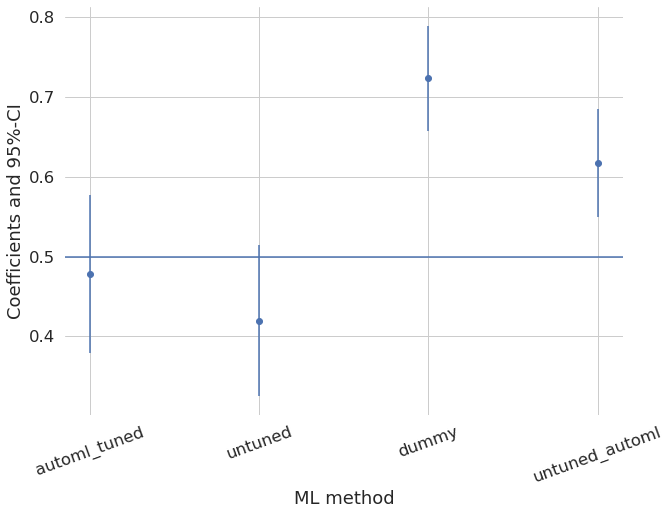

In [30]:
errors = np.full((2, summary.shape[0]), np.nan)
errors[0, :] = summary['coef'] - summary['2.5 %']
errors[1, :] = summary['97.5 %'] - summary['coef']
plt.errorbar(summary.index, summary.coef, fmt='o', yerr=errors)
plt.axhline(0.5)

plt.xlabel('ML method')
plt.ylabel('Coefficients and 95%-CI')
plt.xticks(rotation = 20)
plt.show()

The FLAML AutoML approach leads to the coefficient that is the closest to the actual coefficient with the least wide confidence interval.

In [31]:
scores = {}
scores["automl_tuned"] = print_scores(dml_plr_obj_tuned, True)
scores["untuned"] = print_scores(dml_plr_obj_untuned, True)
scores["dummy"] = print_scores(dml_plr_obj_dummy, True)
scores["automl_untuned"] = print_scores(dml_plr_obj_untuned_automl, True)
scores = pd.DataFrame(scores, index = ["MSE l_of_X", "MSE m_of_X"])
scores

,automl_tuned,untuned,dummy,automl_untuned
MSE l_of_X,1.367688,1.544224,2.035879,1.893867
MSE m_of_X,1.664719,1.806471,2.335472,1.892149


In [32]:
scores.to_pickle("scores_simulated_data_split.pkl")

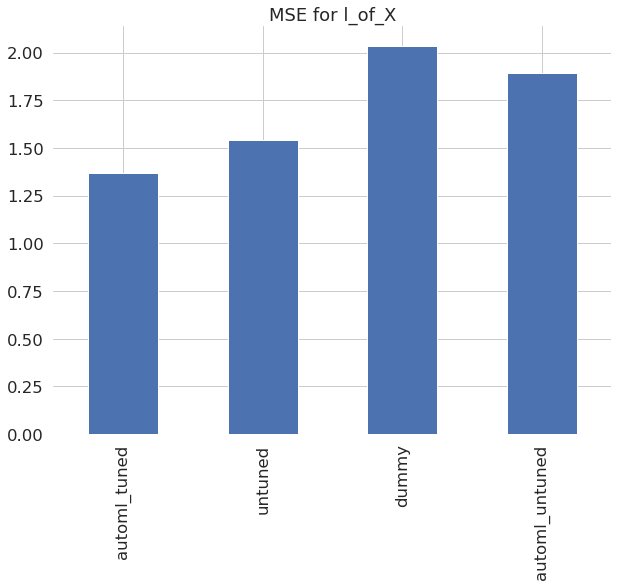

In [33]:
scores.iloc[0].plot(kind="bar", title="MSE for l_of_X");

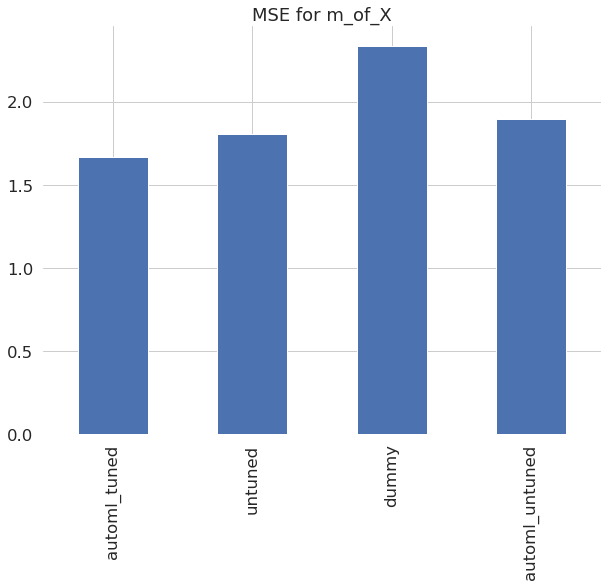

In [34]:
scores.iloc[1].plot(kind="bar", title="MSE for m_of_X");

In all of our tests, we found out that the FLAML AutoML approach leads to the closest coefficient to the true one with the lowest MSE for $ l_{\theta}(X) $ and $ m_{\theta}(X) $. In conclusion, this approach can save a lot of time spent on hyperparameter tuning without compromising performance.